# **CSCI 4967 Projects in AI/ML HW3**

**Spring 2024**

*Author: Yuming (Tao) Xie*

# &nbsp;Part 1

In [41]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.0001):
        self.learning_rate = learning_rate
        self.weights = [np.random.randn(hidden_size, input_size) * 0.01, np.random.randn(output_size, hidden_size) * 0.01]
        self.biases = [np.zeros((hidden_size, 1)), np.zeros((output_size, 1))]

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def relu(self, Z):
        return np.maximum(0, Z)

    def forward_propagation(self, X):
        A = X
        caches = []
        for i in range(len(self.weights)):
            Z = np.dot(self.weights[i], A) + self.biases[i]
            if i != len(self.weights) - 1:
                A = self.relu(Z)
            else:
                A = self.sigmoid(Z)
            caches.append((A, Z))
        return A, caches

    def compute_cost(self, Y, A):
        m = Y.shape[1]
        epsilon = 1e-7
        cost = -np.sum(Y * np.log(A + epsilon) + (1 - Y) * np.log(1 - A + epsilon)) / m
        cost = np.squeeze(cost)
        return cost

    def backward_propagation(self, X, Y, caches):
        grads = {}
        m = X.shape[1]
        Y = Y.reshape(caches[-1][0].shape)

        dAL = -(np.divide(Y, caches[-1][0]) - np.divide(1 - Y, 1 - caches[-1][0]))
        dZ = dAL * self.sigmoid(caches[-1][1]) * (1 - self.sigmoid(caches[-1][1]))
        grads["dW2"] = 1/m * np.dot(dZ, caches[0][0].T)
        grads["db2"] = 1/m * np.sum(dZ, axis=1, keepdims=True)

        dA1 = np.dot(self.weights[1].T, dZ)
        dZ1 = dA1 * (caches[0][1] > 0)
        grads["dW1"] = 1/m * np.dot(dZ1, X.T)
        grads["db1"] = 1/m * np.sum(dZ1, axis=1, keepdims=True)

        return grads

    def update(self, grads):
        self.weights[0] -= self.learning_rate * grads["dW1"]
        self.biases[0] -= self.learning_rate * grads["db1"]
        self.weights[1] -= self.learning_rate * grads["dW2"]
        self.biases[1] -= self.learning_rate * grads["db2"]

    def train(self, X, Y, n_iterations=1000):
        for i in range(n_iterations):
            A, caches = self.forward_propagation(X)
            cost = self.compute_cost(Y, A)
            grads = self.backward_propagation(X, Y, caches)
            self.update(grads)
            if i % 200 == 0: print(f"Iteration {i}: cost = {cost}")

    def predict(self, X):
        A, _ = self.forward_propagation(X)
        predictions = A > 0.5
        return predictions

In [33]:
df['text'] = df['text'].astype(str)
df['review_length'] = df['text'].apply(lambda x: len(x.split()))

df['ratings'] = (df['ratings'] >= 3).astype(int)

scaler = MinMaxScaler()
X_user_id_normalized = scaler.fit_transform(X_user_id)
X_item_id_normalized = scaler.fit_transform(X_item_id)
X_review_length_normalized = scaler.fit_transform(df[['review_length']].values)

X = np.hstack((X_user_id_normalized, X_item_id_normalized, X_review_length_normalized))
y = df['ratings'].values


X_train, X_test, y_train, y_test = split_df(X, y, test_size=0.3, random_state=42)

input_size = X_train.shape[1]
hidden_size = 16
output_size = 1

nn = NeuralNetwork(input_size, hidden_size, output_size)
nn.train(X_train.T, y_train.reshape(1, -1), n_iterations=1000)
y_pred = nn.predict(X_test.T)

accuracy = np.mean(y_pred == y_test.reshape(1, -1))
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Iteration 0: cost = 0.6931610153178925
Iteration 200: cost = 0.6455282491293843
Iteration 400: cost = 0.6024201281070827
Iteration 600: cost = 0.5633796750217644
Iteration 800: cost = 0.527986120885821
Test Accuracy: 100.00%


I used batch gradient descent, since it is simple to implement and is reliable for the binary classification problems.

# &nbsp;Part 2

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import sys
import json
import gzip
import math
import joblib
import random
import scipy.sparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from sklearn.model_selection import train_test_split as split_df
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from urllib.request import urlopen

import warnings
warnings.simplefilter('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models

%matplotlib inline

In [5]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Sports_and_Outdoors.json.gz

--2024-02-09 19:55:29--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Sports_and_Outdoors.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1690448337 (1.6G) [application/x-gzip]
Saving to: ‘Sports_and_Outdoors.json.gz’

Sports_and_Outdoors 100%[===================>]   1.57G   187KB/s    in 1h 52m  

2024-02-09 21:48:11 (244 KB/s) - ‘Sports_and_Outdoors.json.gz’ saved [1690448337/1690448337]



# &nbsp;Task 1

The resource are:
1. https://www.tensorflow.org/tutorials
2. https://www.tensorflow.org/guide/autodiff
3. https://keras.io/guides/sequential_model/
4. https://keras.io/api/models/model_training_apis/

 Implementing a 2-layer NN requires understanding model architecture, forward and backward propagation, loss computation, and optimization. These resources cover these tools and focus on the Tenserflow, including compiling the model, fitting it to the training data, evaluating its performance, and making predictions, leveraging Autograd for gradient computation, and optimization algorithms for model training,

# &nbsp;Task 2

# 2.1&nbsp;Load, Clean and Slice the dataset

In [2]:
# Set the limit
limit = 1000000
counter = 0
data = []

In [3]:
### load the data
with gzip.open('Sports_and_Outdoors.json.gz') as f:         #load the reviews data
    for l in f:
      data.append(json.loads(l.strip()))
      counter+=1
      if counter >= limit: break

In [4]:
df = pd.DataFrame.from_dict(data)

In [5]:
# check the missing values
print('# missing values across all columns:\n',df.isnull().sum())

# missing values across all columns:
 overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          48
reviewText           427
summary              174
unixReviewTime         0
vote              853783
style             457290
image             987976
dtype: int64


In [6]:
# choose the subset useful for further research
df = df[['overall','reviewerID', 'asin', 'reviewText']]
df.drop_duplicates(inplace=True)
df = df.rename(columns={'reviewerID': 'user_id',
                         'asin': 'item_id',
                         'reviewText': 'text',
                         'overall': 'ratings'})

# 2.2.&nbsp;Exploratory Data Analysis

***1. Number of Users and Items.***

In [9]:
print("Fit & Sports Users-Items Summary:")
num_users = df.user_id.nunique()
num_items = df.item_id.nunique()
print("Total # of users:", num_users)
print("Total # of items:", num_items)

Fit & Sports Users-Items Summary:
Total # of users: 817063
Total # of items: 11752


***2. The Ratings Statistics***

In [11]:
df['ratings'].describe()

count    999155.000000
mean          4.270382
std           1.200223
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: ratings, dtype: float64

array([[<Axes: title={'center': 'ratings'}>,
        <Axes: title={'center': 'review_length'}>],
       [<Axes: title={'center': 'review_length_normalized'}>, <Axes: >]],
      dtype=object)

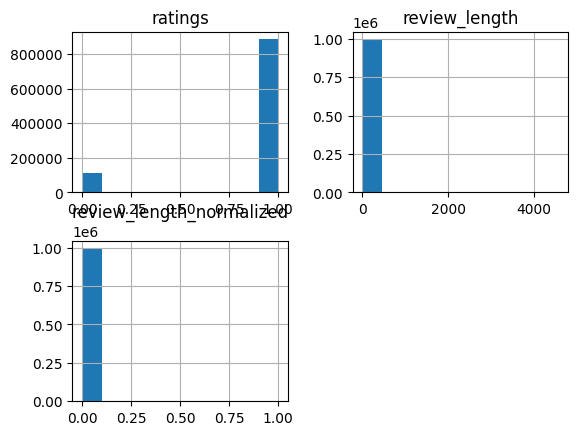

In [13]:
df.hist()

<Axes: ylabel='ratings'>

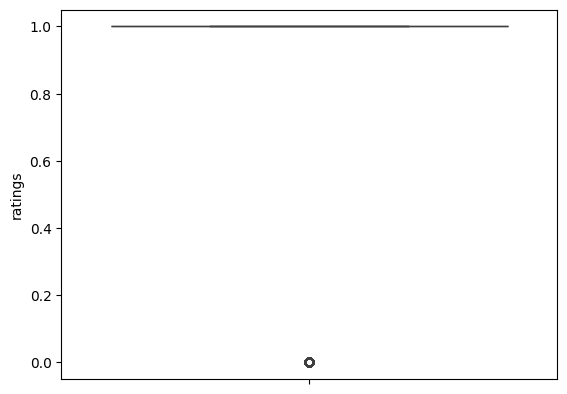

In [21]:
sns.boxplot(y = 'ratings', data = df)

As we can observe, most of reviewers rated the items between 0 and 1.

***3. The Reviews Statistics***

In [15]:
rated = df.groupby('user_id').size().sort_values(ascending=False)

In [16]:
rated.describe()

count    817063.000000
mean          1.222862
std           0.733421
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          78.000000
dtype: float64

<Axes: >

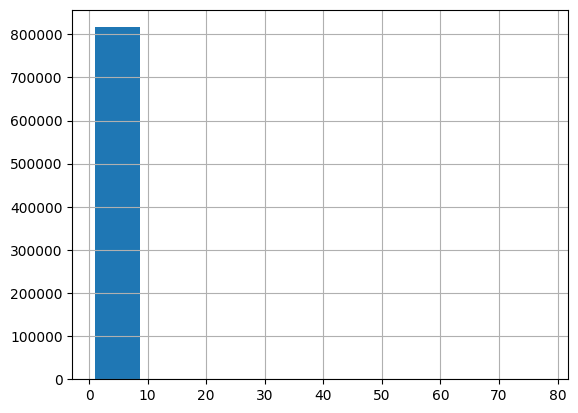

In [17]:
rated.hist()

<Axes: >

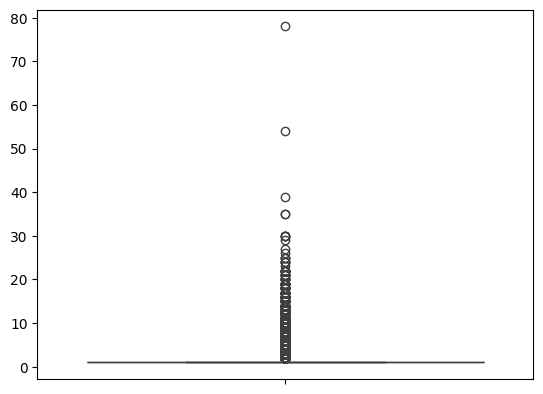

In [18]:
sns.boxplot(data = rated)

As we can observe, most of reviewers wrote reviews between 1 and 40.

In [19]:
print('The Top 5 users who wrote the most reviews: \n',rated[:5])

The Top 5 users who wrote the most reviews: 
 user_id
A3OXHLG6DIBRW8    78
A8VI7KMUHI7ZH     54
A1RPTVW5VEOSI     39
AN81JUYW2SL24     35
A3CYLXCQ6DHU7Y    35
dtype: int64


***4. # Ratings per Item***

In [23]:
num_rating = df.groupby(by='item_id')['ratings'].count().sort_values(ascending=False)
print('The items with the most ratings:')
num_rating.head()

The items with the most ratings:


item_id
7245456313    6685
B000MF63M2    4177
B00008BFYG    4039
B000B6ACGA    3828
B0002ECYRQ    3448
Name: ratings, dtype: int64

In [24]:
print('The average # of ratings per item is {:.0f}.'.format(num_rating.mean()))

The average # of ratings per item is 85.


Text(0.5, 0, 'Product')

Text(0, 0.5, 'Number of Ratings')

Text(0.5, 1.0, 'The Distribution of Number of Ratings per Product')

<function matplotlib.pyplot.show(close=None, block=None)>

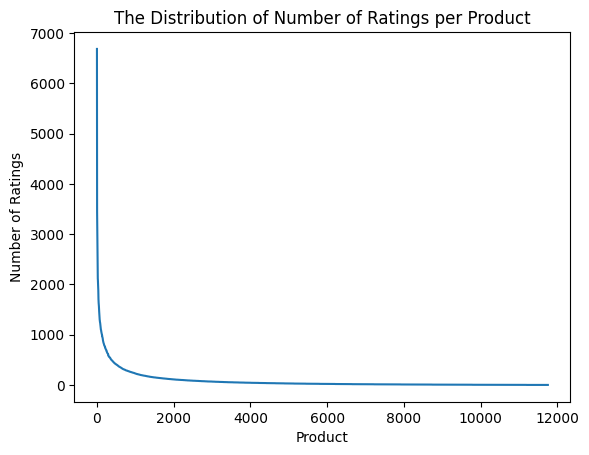

In [25]:
plt.plot(num_rating.values)
plt.xlabel('Product'); plt.ylabel('Number of Ratings');
plt.title('The Distribution of Number of Ratings per Product')
plt.show

As we can observe, the distribution of # ratings per item is left-skewed. Most Items don't have many ratings.

***5. Average Rating Score per Item***

In [26]:
ratings_mean = pd.DataFrame(df.groupby('item_id')['ratings'].mean())
ratings_mean.head()

,ratings
item_id,
0000031895,0.545455
0000032034,0.812500
0692747222,1.000000
0899332757,0.964286
0899333257,0.940000


<Axes: ylabel='Density'>

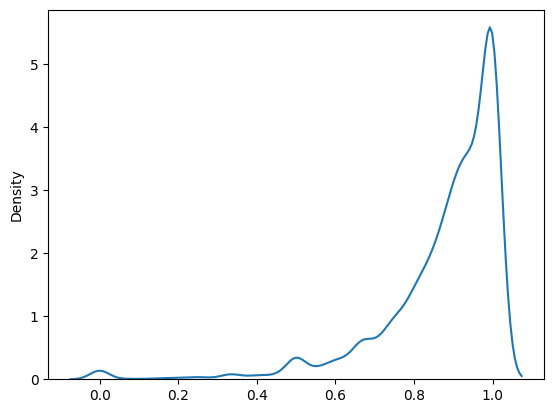

In [27]:
sns.distplot(ratings_mean, hist=False)
plt.show()

As we can observe, the distribution of the average rating score per item is right-skewed. Most Items have high ratings.

# 2.3.&nbsp;Implementation

In [34]:
NN_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(3,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [37]:
NN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
history = NN_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.3)

Epoch 1/20
30600/30600 [==============================] - 93s 3ms/step - loss: 1.5489e-11 - accuracy: 1.0000 - val_loss: 1.3847e-11 - val_accuracy: 1.0000
Epoch 2/20
30600/30600 [==============================] - 89s 3ms/step - loss: 1.2673e-11 - accuracy: 1.0000 - val_loss: 1.1518e-11 - val_accuracy: 1.0000
Epoch 3/20
30600/30600 [==============================] - 92s 3ms/step - loss: 1.0670e-11 - accuracy: 1.0000 - val_loss: 9.8096e-12 - val_accuracy: 1.0000
Epoch 4/20
30600/30600 [==============================] - 92s 3ms/step - loss: 9.1763e-12 - accuracy: 1.0000 - val_loss: 8.5183e-12 - val_accuracy: 1.0000
Epoch 5/20
30600/30600 [==============================] - 91s 3ms/step - loss: 8.0387e-12 - accuracy: 1.0000 - val_loss: 7.5296e-12 - val_accuracy: 1.0000
Epoch 6/20
30600/30600 [==============================] - 92s 3ms/step - loss: 7.1632e-12 - accuracy: 1.0000 - val_loss: 6.7628e-12 - val_accuracy: 1.0000
Epoch 7/20
30600/30600 [==============================] - 90s 3ms/step

# 2.4.&nbsp;Results

In [43]:
test_loss, test_acc = NN_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

9368/9368 [==============================] - 17s 2ms/step - loss: 3.1699e-12 - accuracy: 1.0000
Test Accuracy: 100.00%


# &nbsp;Task 3

The choice of hyperparameters:
1. Number of Neurons in the Hidden Layer: we need to have enough capacity to learn from the data and avoid being too complex for this problem, hence 16 is a good choice.

2. Number of Epochs: Setting the number of epochs to 20 is a choice that balances the trade-offs between the running time and the risk of overfitting.

3. Validation Split: Using 30% of the training data for validation allows for a reasonable estimate of the model's performance on unseen data while retaining most of the data for training.

Rationale behind the technique I used:

1. I used ReLU for the hidden layer because it introduces nonlinearility into the model, hence helps mitigate the vanishing gradient problem, allowing models to learn faster and perform better.

2. I used Sigmoid in the output layer for this model because it outputs probabilities which is ideal in binary classification tasks.

Regularization

I didn't do the dropouts or L2 norm in the model to prevent overfitting, instead, I used cross validation since this is one of the recommendation method on lecture slides and it does the same thing. :)

Optimization Algorithm

I used Adam because it is computationally efficient, requires little memory, and adjusts the learning rate on a per-parameter basis, making it suitable for this problem.